### OD矩阵预测
观察数据，发现绝大多数OD对都没有出行量，OD矩阵非常稀疏。直接进行预测的效果难以预测。本问题不只需要对OD对的trip做出预测，还需要对矩阵中存在的OD对做出预测。首先舍去出行距离大于3.5的od对（0_removed）

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression 

In [4]:
columns=['ori','dst','dist_km','fsize_m6_wd_pm','trip_m6_wd_pm',
                                'community_m6','mrt_km_o','entro_o','cycle_km_o',
                                'far_hdb_o','far_priv_o','far_comm_o','mrt_km_d',
                                'entro_d','cycle_km_d','far_hdb_d','far_priv_d','far_comm_d',
                                'ori_lat','ori_lon','dst_lat','dst_lon']
ycol='trip_m6_wd_pm'
columns.remove(ycol)
features=columns                                                         

In [5]:
data=pd.read_csv('1.csv')
data=data.sort_values(by='trip_m6_wd_pm')
trip=data['trip_m6_wd_pm']


In [57]:
bins=[-0.1,0.5,5000]
cut_res=pd.cut(trip,bins=bins,labels=[0,1])

In [63]:
trip.describe()

count    241238.000000
mean          1.062805
std           4.071874
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         283.000000
Name: trip_m6_wd_pm, dtype: float64

In [64]:
cut_res

0         0
148038    0
148039    0
148040    0
148041    0
         ..
56641     1
19106     1
56855     1
20780     1
39529     1
Name: trip_m6_wd_pm, Length: 241238, dtype: category
Categories (2, int64): [0 < 1]

In [65]:
data['has_trip']=cut_res

In [4]:
plt.style.use("bmh")
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [67]:
ycol='has_trip'
xcol=['dist_km',
            'community_m6','mrt_km_o','entro_o','cycle_km_o',
                                'far_hdb_o','far_priv_o','far_comm_o','mrt_km_d',
                                'entro_d','cycle_km_d','far_hdb_d','far_priv_d','far_comm_d']
y=data[ycol]
X=data[xcol]                                

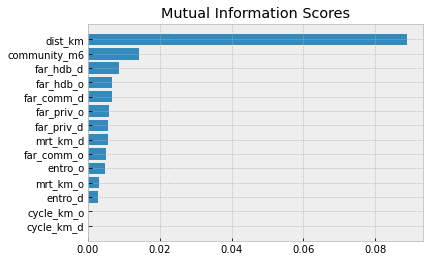

In [50]:
scores=make_mi_scores(X, y)
plot_mi_scores(scores)

### 3.1 挑战

#### (1) 数据稀疏：即使是庞大的trip数据集也难以覆盖所有时间段的所有区域对，从而产生稀疏的随机OD矩阵；稀疏体现在矩阵中一些元素是全为零的空向量（如图1(b)中的？）

#### (2) 时空关联：OD矩阵本身并不一定能捕获空间接近性，因为难以保证两个地理上相邻的区域在矩阵中是由相邻的行和列表示的。因此，需要一种单独的机制，能够考虑到在OD矩阵中很好地表示的区域的地理邻近性。此外，还应考虑时间依赖性。


可以看出在地域空间之外，距离对od的产生有决定性的影响

In [68]:
def group_plot(data,groupby,ratio):
    # data=sample(data,ratio)
    cut_tar=data[groupby].values
    bins=[-0.1]+list(data[groupby].describe()[4:8])
    # cut_res=pd.cut(cut_tar,bins=bins,labels=['a','b','c','d'])
    cut_res=pd.cut(cut_tar,bins=bins,labels=['a','b','c','d'])
    data['cat_var_'+groupby]=cut_res
    return data
    # sns.lmplot(data=data,x='fsize_m6_wd_pm',y='trip_m6_wd_pm',col='cat_var'+groupby,col_wrap=2)
data=group_plot(data,'dist_km',0.5)
group_data=data.groupby('cat_var_dist_km')



In [69]:
data['dist_km'].describe()

count    241238.000000
mean          2.587697
std           1.815588
min           0.000000
25%           1.340000
50%           2.130000
75%           3.330000
max          20.650000
Name: dist_km, dtype: float64

<AxesSubplot:xlabel='cat_var_dist_km'>

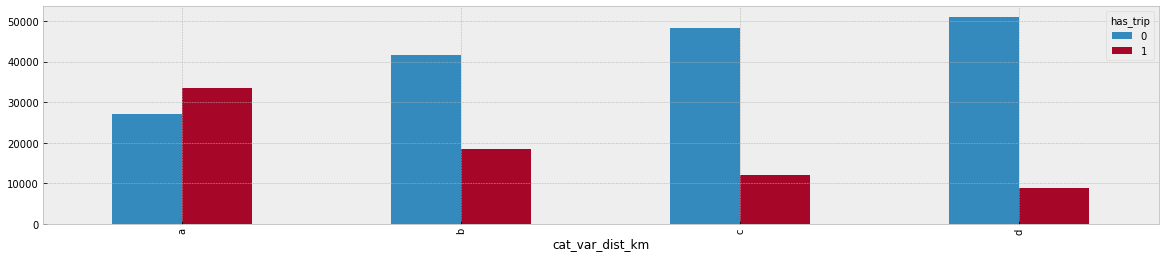

In [70]:
group_data['has_trip'].value_counts().unstack().plot(kind='bar', figsize=(20, 4))

观察不同出行距离分组下，OD对的有无。再看网络社区的绘图,发现同一社区中有出行的概率更高。

<AxesSubplot:xlabel='community_m6'>

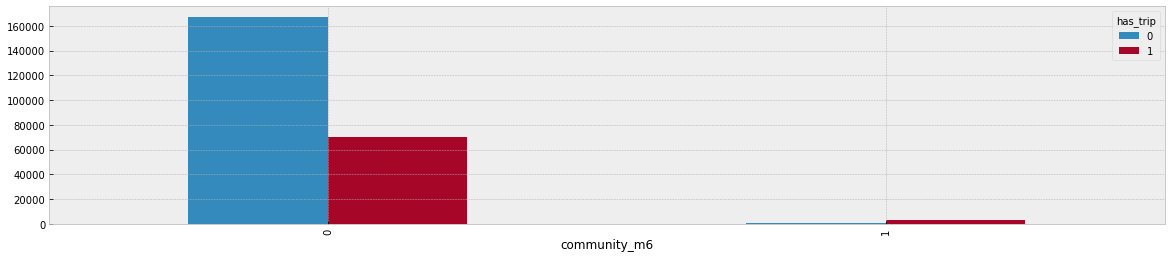

In [71]:
data.groupby('community_m6')['has_trip'].value_counts().unstack().plot(kind='bar', figsize=(20, 4))

In [168]:
datax=data.sort_values('trip_m6_wd_pm')
datax.tail()

,ori,dst,dist_km,fsize_m6_wd_pm,trip_m6_wd_pm,community_m6,mrt_km_o,entro_o,cycle_km_o,far_hdb_o,far_priv_o,far_comm_o,mrt_km_d,entro_d,cycle_km_d,far_hdb_d,far_priv_d,far_comm_d
56641,5998,5997,0.68,273.090909,170,1,0.58,0.653604,0.00,1.165353,0.000000,0.312576,0.34,0.838065,0.00,0.012546,0.821470,0.000000
19106,2785,2605,1.50,158.545455,180,0,0.34,0.766682,0.08,0.114095,0.000000,0.615088,1.27,0.000000,0.34,1.461048,0.000000,0.022270
56855,6178,5998,0.55,140.727273,186,0,0.48,0.690257,0.00,0.034300,1.194264,0.005930,0.58,0.653604,0.00,1.165353,0.000000,0.312576
20780,2605,2785,1.87,161.863636,221,0,1.27,0.000000,0.34,1.461048,0.000000,0.022270,0.34,0.766682,0.08,0.114095,0.000000,0.615088
39529,5094,5094,0.00,117.045454,283,0,0.91,0.869225,0.00,0.000000,0.373207,0.000000,0.91,0.869225,0.00,0.000000,0.373207,0.000000


检查发现土地利用数据中entro缺失严重，非常不正常。先获取各区块相邻关系。
在smooth_entro.py中对entro_o和entro_d进行平滑处理，再检查互信息情况如下，可以发现效果尚可


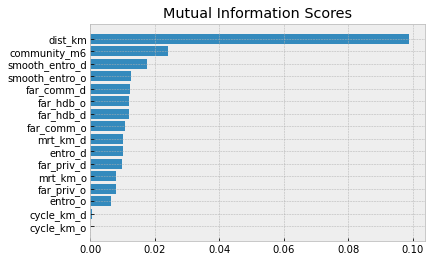

In [179]:
seo_data=pd.read_csv('smooth_entro.csv')

seo_data=seo_data.sort_values(by='trip_m6_wd_pm')

trip=seo_data['trip_m6_wd_pm']

bins=[-0.1,0.5,5000]
cut_res=pd.cut(trip,bins=bins,labels=[0,1])

seo_data['has_trip']=cut_res
ycol='has_trip'
xcol=['dist_km',
            'community_m6','mrt_km_o','entro_o','cycle_km_o',
                                'far_hdb_o','far_priv_o','far_comm_o','mrt_km_d',
                                'entro_d','cycle_km_d','far_hdb_d','far_priv_d','far_comm_d',
                                'smooth_entro_o','smooth_entro_d']
y=seo_data[ycol]
X=seo_data[xcol]


scores=make_mi_scores(X, y)
plot_mi_scores(scores)                              

'ori','dst','dist_km','fsize_m6_wd_pm','trip_m6_wd_pm',
                                'community_m6','mrt_km_o','entro_o','cycle_km_o',
                                'far_hdb_o','far_priv_o','far_comm_o','mrt_km_d',
                                'entro_d','cycle_km_d','far_hdb_d','far_priv_d','far_comm_d',
                                'ori_lat','ori_lon','dst_lat','dst_lon'

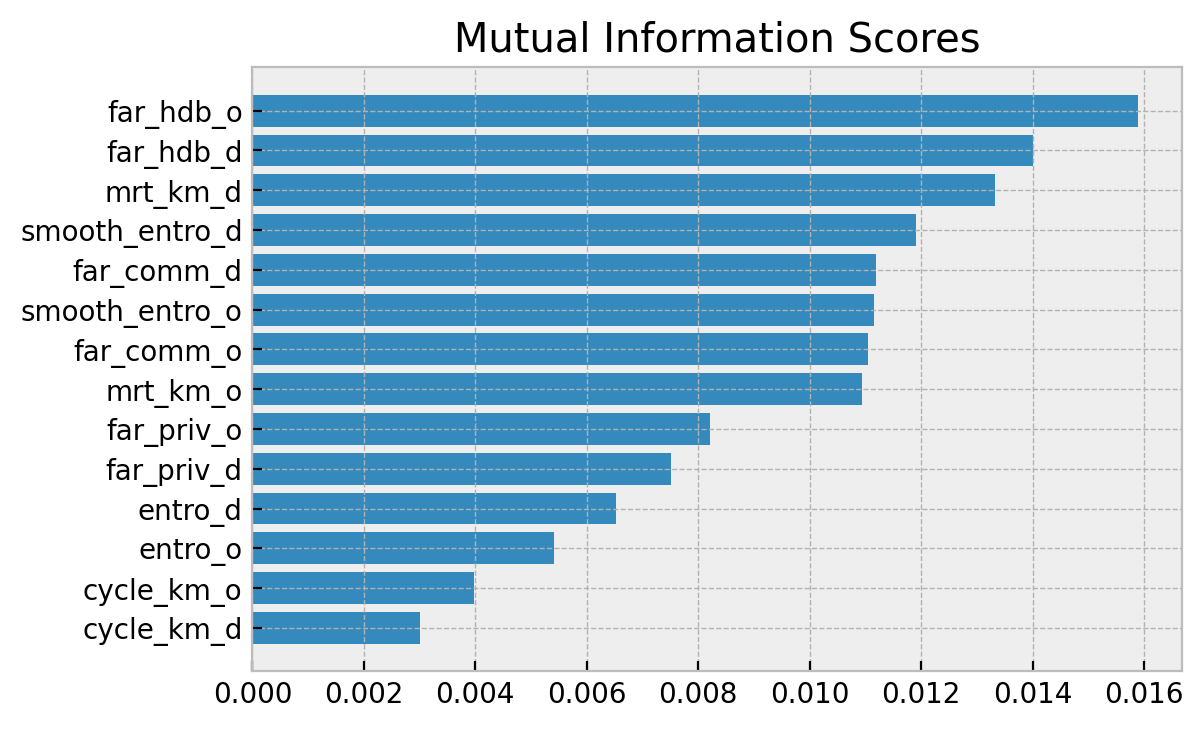

In [7]:
seo_data=pd.read_csv('smooth_entro.csv')

seo_data=seo_data.sort_values(by='trip_m6_wd_pm')

trip=seo_data['trip_m6_wd_pm']

bins=[-0.1,0.5,5000]
cut_res=pd.cut(trip,bins=bins,labels=[0,1])

seo_data['has_trip']=cut_res
ycol='trip_m6_wd_pm'
xcol=[
            'mrt_km_o','entro_o','cycle_km_o',
                                'far_hdb_o','far_priv_o','far_comm_o','mrt_km_d',
                                'entro_d','cycle_km_d','far_hdb_d','far_priv_d','far_comm_d',
                                'smooth_entro_o','smooth_entro_d']
y=seo_data[ycol]
X=seo_data[xcol]


scores=make_mi_scores(X, y)
plt.figure(dpi=200)
plt.style.use('bmh')

plot_mi_scores(scores)   
plt.savefig('im_built.jpg')

In [178]:
seo_data['trip_m6_wd_pm'].describe()

count    241238.000000
mean          1.062805
std           4.071874
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         283.000000
Name: trip_m6_wd_pm, dtype: float64